In [6]:
import os
import pathlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display as ld
from IPython.display import Audio
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPool1D, MaxPooling1D, Conv2D,MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
sns.set()

{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav

    - {FOLD}- índice da dobra de validação cruzada,
    - {CLIP_ID}- ID do clipe original do Freesound,
    - {TAKE}- carta desambiguando entre diferentes fragmentos do mesmo clipe Freesound,
    - {TARGET}- classe em formato numérico [0, 49]


In [7]:
archive = pd.read_csv('ESC-50/meta/esc50.csv')
fold = []
clip_id = []
take = []
target = []
dirpath = []

for root, dirs, filename in tqdm(os.walk('ESC-50/audio')):
    for file in filename:

        try:
            fold.append(file.split('-')[0])
            clip_id.append(file.split('-')[1])
            take.append(file.split('-')[2])
            target.append(file.split('-')[3].replace('.wav',''))

            dirpath.append((root, file))

        except ValueError:
            continue

1it [00:00,  1.18it/s]


In [8]:

category = archive[['target','category']]
category['target']= category['target'].astype(str)
category = dict(category.drop_duplicates().values)

In [9]:
df = pd.DataFrame([fold, clip_id, take, target, dirpath]).T
df.columns = ['fold', 'clip_id', 'take', 'target', 'dirpath']
df['category'] = df['target'].map(category)
df['path'] = df['dirpath'].apply(lambda x: x[0] + '/' + x[1])

In [10]:
df

,fold,clip_id,take,target,dirpath,category,path
0,1,100032,A,0,"(ESC-50/audio, 1-100032-A-0.wav)",dog,ESC-50/audio/1-100032-A-0.wav
1,1,100038,A,14,"(ESC-50/audio, 1-100038-A-14.wav)",chirping_birds,ESC-50/audio/1-100038-A-14.wav
2,1,100210,A,36,"(ESC-50/audio, 1-100210-A-36.wav)",vacuum_cleaner,ESC-50/audio/1-100210-A-36.wav
3,1,100210,B,36,"(ESC-50/audio, 1-100210-B-36.wav)",vacuum_cleaner,ESC-50/audio/1-100210-B-36.wav
4,1,101296,A,19,"(ESC-50/audio, 1-101296-A-19.wav)",thunderstorm,ESC-50/audio/1-101296-A-19.wav
...,...,...,...,...,...,...,...
1995,5,263831,B,6,"(ESC-50/audio, 5-263831-B-6.wav)",hen,ESC-50/audio/5-263831-B-6.wav
1996,5,263902,A,36,"(ESC-50/audio, 5-263902-A-36.wav)",vacuum_cleaner,ESC-50/audio/5-263902-A-36.wav
1997,5,51149,A,25,"(ESC-50/audio, 5-51149-A-25.wav)",footsteps,ESC-50/audio/5-51149-A-25.wav
1998,5,61635,A,8,"(ESC-50/audio, 5-61635-A-8.wav)",sheep,ESC-50/audio/5-61635-A-8.wav


Canais:  1
Numero total de amostras:  220500
Arquivo:  ESC-50/audio/1-40967-A-28.wav
Taxa de Amostragem:  44100
['1' '40967' 'A' '28' ('ESC-50/audio', '1-40967-A-28.wav') 'snoring'
 'ESC-50/audio/1-40967-A-28.wav']


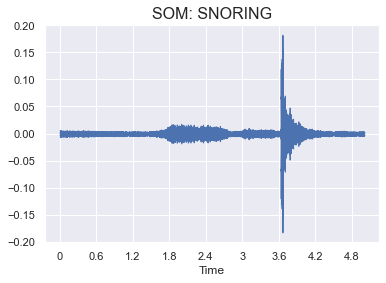

In [11]:

rdn = np.random.randint(1, df.shape[0])
fname = df['path'][rdn]

data, sample_rate = librosa.load(fname, sr=None)

print("Canais: ", len(data.shape))
print("Numero total de amostras: ", data.shape[0])
print("Arquivo: ", fname)
print("Taxa de Amostragem: ", sample_rate)

info = df.iloc[rdn].values
print(info)
title_txt = "Som: " + info[5]
plt.title(title_txt.upper(), size = 16)
librosa.display.waveshow(data ,sr = sample_rate)
Audio(data= data, rate= sample_rate)

In [14]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [15]:
bands=60
frames=41
window_size = 512 * (frames - 1)
log_specgrams = []
for path in tqdm(df['path'].values):
    y, sample_rate = librosa.load(path,)
    for(start, end) in windows(y, window_size):
        if len(y[start:end]) == window_size:
            signal = y[start:end]
            melspec = librosa.feature.melspectrogram(signal, n_mels=bands)
            logspec = librosa.power_to_db(melspec, ref=np.max)
            logspec = logspec.T.flatten()[:, np.newaxis].T
    log_specgrams.append(logspec)

log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams), bands, frames, 1)
features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis=3)
for i in range(len(features)):
    features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:17<00:00,  4.02it/s]


In [19]:
features = np.array(features)

In [22]:
features.shape

(2000, 60, 41, 2)

In [11]:
y = np.array(df['category'].to_list())

In [18]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
